# micrograd exercises

1. watch the [micrograd video](https://www.youtube.com/watch?v=VMj-3S1tku0) on YouTube
2. come back and complete these exercises to level up :)

## section 1: derivatives

In [1]:
# here is a mathematical expression that takes 3 inputs and produces one output
from math import sin, cos

def f(a, b, c):
  return -a**3 + sin(3*b) - 1.0/c + b**2.5 - a**0.5

print(f(2, 3, 4))

6.336362190988558


In [2]:
# write the function df that returns the analytical gradient of f
# i.e. use your skills from calculus to take the derivative, then implement the formula
# if you do not calculus then feel free to ask wolframalpha, e.g.:
# https://www.wolframalpha.com/input?i=d%2Fda%28sin%283*a%29%29%29

def gradf(a, b, c):
  return [-3*a**2-0.5*(a**-0.5),3*cos(3*b)+2.5*b**1.5 ,1/c**2] # todo, return [df/da, df/db, df/dc]

# expected answer is the list of
ans = [-12.353553390593273, 10.25699027111255, 0.0625]
yours = gradf(2, 3, 4)
for dim in range(3):
  ok = 'OK' if abs(yours[dim] - ans[dim]) < 1e-5 else 'WRONG!'
  print(f"{ok} for dim {dim}: expected {ans[dim]}, yours returns {yours[dim]}")


OK for dim 0: expected -12.353553390593273, yours returns -12.353553390593273
OK for dim 1: expected 10.25699027111255, yours returns 10.25699027111255
OK for dim 2: expected 0.0625, yours returns 0.0625


In [3]:
# now estimate the gradient numerically without any calculus, using
# the approximation we used in the video.
# you should not call the function df from the last cell

# -----------
h=0.000001
a,b,c=2,3,4
numerical_grad = [(f(a+h,b,c)-f(a,b,c))/h, (f(a,b+h,c)-f(a,b,c))/h, (f(a,b,c+h)-f(a,b,c))/h] # TODO
# -----------

for dim in range(3):
  ok = 'OK' if abs(numerical_grad[dim] - ans[dim]) < 1e-5 else 'WRONG!'
  print(f"{ok} for dim {dim}: expected {ans[dim]}, yours returns {numerical_grad[dim]}")


OK for dim 0: expected -12.353553390593273, yours returns -12.353559348809995
OK for dim 1: expected 10.25699027111255, yours returns 10.256991666679482
OK for dim 2: expected 0.0625, yours returns 0.062499984743169534


In [4]:
# there is an alternative formula that provides a much better numerical
# approximation to the derivative of a function.
# learn about it here: https://en.wikipedia.org/wiki/Symmetric_derivative
# implement it. confirm that for the same step size h this version gives a
# better approximation.

# -----------
h=0.000001
numerical_grad2 = [(f(a+h,b,c)-f(a-h,b,c))/(2*h), (f(a,b+h,c)-f(a,b-h,c))/(2*h), (f(a,b,c+h)-f(a,b,c-h))/(2*h)] # TODO
# -----------

for dim in range(3):
  ok = 'OK' if abs(numerical_grad2[dim] - ans[dim]) < 1e-5 else 'WRONG!'
  print(f"{ok} for dim {dim}: expected {ans[dim]}, yours returns {numerical_grad2[dim]}")


OK for dim 0: expected -12.353553390593273, yours returns -12.353553391353245
OK for dim 1: expected 10.25699027111255, yours returns 10.25699027401572
OK for dim 2: expected 0.0625, yours returns 0.06250000028629188


## section 2: support for softmax

In [19]:
# Value class starter code, with many functions taken out
from math import exp, log

class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other): # exactly as in the video
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  # ------
  # re-implement all the other functions needed for the exercises below
  # your code here


  def __mul__(self, other) :

     other = other if isinstance(other, Value) else Value(other)
     out = Value(self.data * other.data, (self, other), '*')

     def _backward():
        self.grad += other.data * out.grad
        other.grad += self.data * out.grad
     out._backward = _backward
     return out

  def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out

  def log(self):
    out = Value(log(self.data), (self,), 'log')

    def _backward():
      self.grad += (1/self.data) * out.grad
    out._backward = _backward
    return out

  def __truediv__(self, other):
    other = Value(other) if not isinstance(other, Value) else other
    return self * other**-1

  def __rtruediv__(self, other): # other / self
    return other * self**-1

  def __neg__(self):
    return self * -1

  def __sub__(self, other):
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other


  def __rmul__(self,other):
    return self * other

  def exp(self):
    x = self.data
    out = Value(exp(x), (self,) , 'exp')

    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward

    return out

  def tanh(self):
      x = self.data
      t = (exp(2*x) - 1)/(exp(2*x) + 1)
      out = Value(t, (self, ), 'tanh')

      def _backward():
          self.grad += (out.data > 0) * out.grad
      out._backward = _backward

      return out



  # ------

  def backward(self): # exactly as in video
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [20]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})

    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

##


In [21]:

x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

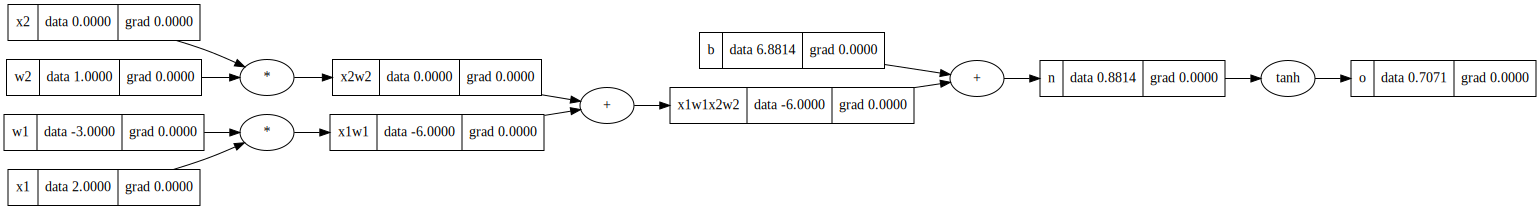

In [22]:
draw_dot(o)

In [23]:
o.backward()


In [24]:
# without referencing our code/video __too__ much, make this cell work
# you'll have to implement (in some cases re-implemented) a number of functions
# of the Value object, similar to what we've seen in the video.
# instead of the squared error loss this implements the negative log likelihood
# loss, which is very often used in classification.

# this is the softmax function
# https://en.wikipedia.org/wiki/Softmax_function

def softmax(logits):
  counts = [logit.exp() for logit in logits]
  denominator = sum(counts)
  out = [c / denominator for c in counts]
  return out

# this is the negative log likelihood loss function, pervasive in classification
logits = [Value(0.0), Value(3.0), Value(-2.0), Value(1.0)]
probs = softmax(logits)
loss = -probs[3].log() # dim 3 acts as the label for this input example
loss.backward()
print(loss.data)

ans = [0.041772570515350445, 0.8390245074625319, 0.005653302662216329, -0.8864503806400986]
for dim in range(4):
  ok = 'OK' if abs(logits[dim].grad - ans[dim]) < 1e-5 else 'WRONG!'
  print(f"{ok} for dim {dim}: expected {ans[dim]}, yours returns {logits[dim].grad}")


2.1755153626167147
OK for dim 0: expected 0.041772570515350445, yours returns 0.041772570515350445
OK for dim 1: expected 0.8390245074625319, yours returns 0.8390245074625319
OK for dim 2: expected 0.005653302662216329, yours returns 0.005653302662216329
OK for dim 3: expected -0.8864503806400986, yours returns -0.8864503806400986


In [ ]:
# verify the gradient using the torch library
# torch should give you the exact same gradient
import torch


In [ ]:
import micrograd as mg

class Tensor:
    def __init__(self, data):
        self.data = data
        self.grad = None

    def backward(self):
        if self.grad is None:
            self.grad = mg.Tensor(np.ones_like(self.data))

    def __repr__(self):
        return f"Tensor({self.data})"

    def __add__(self, other):
        return Tensor(self.data + other.data)

    def __mul__(self, other):
        return Tensor(self.data * other.data)

def softmax(logits):
    exp_logits = [mg.exp(logit) for logit in logits]
    exp_sum = sum(exp_logits)
    softmax_probs = [exp_logit / exp_sum for exp_logit in exp_logits]
    return softmax_probs

# Example usage
logits = [Tensor(2), Tensor(3), Tensor(1)]
softmax_probs = softmax(logits)
print(softmax_probs)